<a href="https://colab.research.google.com/github/daisuke14012719/DeepLearning/blob/main/fruit_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import torch
import random
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
#import torchvision.transforms as transforms
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import torch.optim as optim
from torch.autograd import Variable
%matplotlib inline

device = 'cuda:0'

In [ ]:
class FruitDataset(Dataset):
    def __init__(self, directory, transform):
        self.directory = directory
        self.image_and_label = self.image()
        self.transform = transform

    def image(self):
        image_and_label = []
        for folder in os.listdir(self.directory):
            folder_path = os.path.join(self.directory, folder)

            if os.path.isdir(folder_path):
                for file in os.listdir(folder_path):
                    file_path = os.path.join(folder_path, file)

                    if os.path.isfile(file_path) and file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff')):
                        image_and_label.append((file_path, folder))
        
        return image_and_label

    
    def __len__(self):
        return len(self.image_and_label)

    def __getitem__(self, index):
        images, labels = self.image_and_label[index]
        image = Image.open(images)
        dir_names = [d.name for d in os.scandir(self.directory)]
        dir_names.sort()
        dir_to_index = {dir_name: i for i, dir_name in enumerate(dir_names)}
        label = dir_to_index[labels]
        label_tensor = torch.tensor(label)
        
        if self.transform:
            image = self.transform(image)

        return image, label_tensor


In [ ]:
#{'apple': 0, 'avocado': 1, 'banana': 2, 'cherry': 3, 'kiwifruit': 4, 'mango': 5, 'orange': 6, 'pineapple': 7, 'strawberry': 8, 'watermelon': 9}

transform = transforms.Compose([transforms.CenterCrop(128), transforms.Grayscale(1), transforms.ToTensor()])

train_directory = './drive/MyDrive/DeepLearning/fruit/train'
test_directory = './drive/MyDrive/DeepLearning/fruit/test'

train_dataset = FruitDataset(train_directory, transform)
test_dataset = FruitDataset(test_directory, transform)

print(train_dataset[0])
print(len(train_dataset))

print(test_dataset[0])
print(len(test_dataset))

(tensor([[[0.1529, 0.1922, 0.2000,  ..., 0.1490, 0.1922, 0.2039],
         [0.1725, 0.2039, 0.2118,  ..., 0.1294, 0.1373, 0.1137],
         [0.2039, 0.2196, 0.2235,  ..., 0.0941, 0.1412, 0.1216],
         ...,
         [0.1059, 0.1725, 0.0941,  ..., 0.1333, 0.1490, 0.1686],
         [0.1647, 0.0941, 0.0980,  ..., 0.0980, 0.0902, 0.0863],
         [0.1020, 0.0784, 0.2118,  ..., 0.3098, 0.2980, 0.2941]]]), tensor(3))
2392
(tensor([[[0.7020, 0.7020, 0.7020,  ..., 0.7333, 0.7333, 0.7333],
         [0.7020, 0.7020, 0.7059,  ..., 0.7373, 0.7373, 0.7373],
         [0.7059, 0.7059, 0.7098,  ..., 0.7412, 0.7412, 0.7412],
         ...,
         [0.5843, 0.5490, 0.4431,  ..., 0.3216, 0.3333, 0.3686],
         [0.7725, 0.7608, 0.7961,  ..., 0.4078, 0.4902, 0.6000],
         [0.7765, 0.7882, 0.7294,  ..., 0.7412, 0.8000, 0.8157]]]), tensor(2))
1120


In [ ]:
#損失関数
criterion = nn.CrossEntropyLoss().to(device)

#データローダー
train_dataloader = DataLoader(train_dataset, batch_size=500, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=200, shuffle=True)

print(len(train_dataloader))
print(len(test_dataloader))

5
6


In [ ]:
class FruitNet(nn.Module):
    def __init__(self):
        super(FruitNet, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 16, 4, 2, 1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(16, 32, 4, 2, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32, 64, 4, 2, 1),
            #nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 128, 3, 1, 1),
            #nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 256, 3, 1, 1),
            #nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.lin = nn.Sequential(
            nn.Linear(8*8*256, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)           
        )
        
    
    def forward(self, x):
        x = self.cnn(x)
        x = x.view(-1, 8*8*256)
        x = self.lin(x)
        
        return x

In [ ]:
net = FruitNet().to(device)
print(net)
print(summary(net, (1, 128, 128)))

FruitNet(
  (cnn): Sequential(
    (0): Conv2d(1, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (8): ReLU()
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU()
  )
  (lin): Sequential(
    (0): Linear(in_features=16384, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=512, bias=True)
  

In [ ]:
loss_list = []
test_loss_list = []
acc_list = []
base_epoch = 0

optimizer = optim.Adam(params=net.parameters(), lr=0.001)

In [ ]:
for epoch in range(35):
    net.train()
    total_loss = 0
    for data in train_dataloader:
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs.to(device))
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    loss_list.append(total_loss/len(train_dataset))

    correct = 0
    total = 0
    total_test_loss = 0
    net.eval()
    for data in test_dataloader:
        inputs, labels = data
        outputs = net(inputs.to(device))
        test_loss = criterion(outputs, labels.to(device))
        total_test_loss += test_loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum()
    
    test_loss_list.append(total_test_loss/total)
    acc_list.append(float(correct)/total)


    print('{}epoch : train_loss:{}, test_loss:{}, test_acc:{}'.format(
        base_epoch + epoch + 1,
        total_loss/len(train_dataset),
        total_test_loss/len(test_dataset),
        float(correct)/total
    ))

print('end of study')
base_epoch += epoch + 1

1epoch : train_loss:0.0048110088377094585, test_loss:0.012281893832342966, test_acc:0.13482142857142856
2epoch : train_loss:0.004628469214391549, test_loss:0.012384227982589176, test_acc:0.1357142857142857
3epoch : train_loss:0.004413597659522475, test_loss:0.013529426285198756, test_acc:0.11071428571428571
4epoch : train_loss:0.004397841301251415, test_loss:0.01384611874818802, test_acc:0.10267857142857142
5epoch : train_loss:0.004213880834770841, test_loss:0.013232298833983285, test_acc:0.09910714285714285
6epoch : train_loss:0.004139542579650879, test_loss:0.013502766191959382, test_acc:0.125
7epoch : train_loss:0.004026371051236538, test_loss:0.012295171192714146, test_acc:0.13660714285714284
8epoch : train_loss:0.004016756263863682, test_loss:0.012184061748640878, test_acc:0.15446428571428572
9epoch : train_loss:0.0039578087652806055, test_loss:0.012293120792933872, test_acc:0.14642857142857144
10epoch : train_loss:0.003874559516093404, test_loss:0.011524716445377895, test_acc:0.2

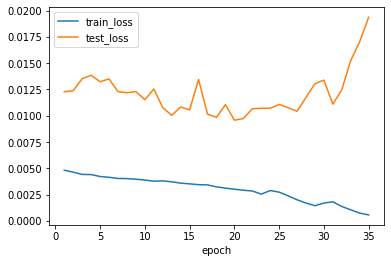

In [ ]:
plt.figure()
plt.plot(range(1, len(loss_list)+1), loss_list, label='train_loss')
plt.plot(range(1, len(test_loss_list)+1), test_loss_list, label='test_loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

正解データ
不正解データ


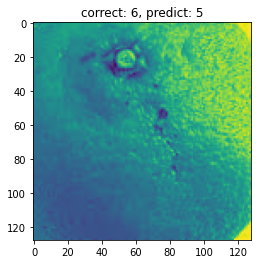

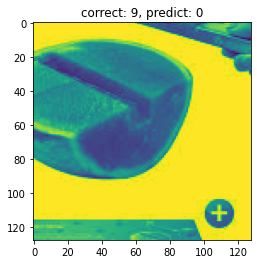

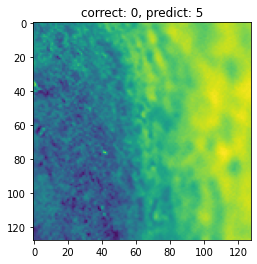

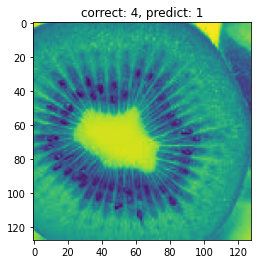

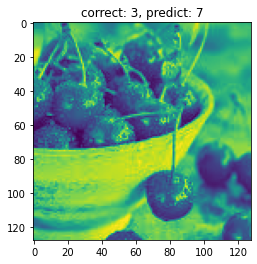

In [ ]:
test_iter = iter(test_dataloader)
true_list = []
false_list = []
inputs, labels = next(test_iter)
outputs = net(Variable(inputs.cuda()))
_, predicted = torch.max(outputs.data, 1)

for idx in range(len(labels)):
    list = [inputs[idx], labels[idx], predicted[idx]]
    if int(labels[idx]) == int(predicted[idx]):
        true_list.append(list)
    else:
        false_list.append(list)

print('正解データ')
for idx, tlst in enumerate(true_list[:5]):
    plt.figure(idx+1)   
    plt.imshow(tlst[0].numpy().reshape(128, 128))
    plt.title('correct: {}, predict: {}'.format(tlst[1], tlst[2]))
    

print('不正解データ')
for idx, flst in enumerate(false_list[:5]):
    plt.figure(idx+1)   
    plt.imshow(flst[0].numpy().reshape(128, 128))
    plt.title('correct: {}, predict: {}'.format(flst[1], flst[2]))